In [346]:
import joblib
import numpy as np
import pandas as pd
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

data = pd.read_csv('./Sourcecode/bitcoin_df.csv')
# chỉ lấy data từ 2020 trở đi
data = data[data['Date'] >= '2021-01-01']
df1 = data[['Date', 'Close']]
df1['log_return'] = np.log(df1['Close'] / df1['Close'].shift(1))
df1['log_return'] = df1['log_return'].fillna(0)
# arma test
par = 1
qar = 1
modelarma = ARIMA(df1['log_return'], order=(par, 1, qar))
modelarima_fit = modelarma.fit()
df1['Arma_resid'] = modelarima_fit.resid
model_garch = arch_model(df1['log_return'].dropna(), vol='Garch', p=9, q=7)
garch_result = model_garch.fit(disp="off")
df1['GARCH_Residuals'] = garch_result.resid
model_garch_Arima = arch_model(df1['Arma_resid'].dropna(), vol='Garch', p=1, q=1)
arima_garch_result = model_garch_Arima.fit(disp="off")
df1['Arima_GARCH_Residuals'] = arima_garch_result.resid

C:\Users\ThinhDo\AppData\Local\Temp\ipykernel_10492\1540515948.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['log_return'] = np.log(df1['Close'] / df1['Close'].shift(1))
C:\Users\ThinhDo\AppData\Local\Temp\ipykernel_10492\1540515948.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['log_return'] = df1['log_return'].fillna(0)
c:\Users\ThinhDo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and w

In [347]:
# tạo df2 lấy dữ liệu từ đầu đến 2023-01-01 trong df1
df2 = df1[df1['Date'] <= '2022-01-01']
df2
model_garch = arch_model(df2['log_return'].dropna(), vol='Garch', p=9, q=7)
garch_result = model_garch.fit(disp="off")
df2['GARCH_Residuals1'] = garch_result.resid
model_garch_Arima = arch_model(df2['Arma_resid'].dropna(), vol='Garch', p=1, q=1)
arima_garch_result = model_garch_Arima.fit(disp="off")
df2['Arima_GARCH_Residuals1'] = arima_garch_result.resid

c:\Users\ThinhDo\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00176. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\ThinhDo\AppData\Local\Temp\ipykernel_10492\2519149699.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['GARCH_Residuals1'] = garch_result.resid
c:\Users\ThinhDo\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:311: D

In [353]:
# Tạo forecastdf từ df1['Arima_GARCH_Residuals'] và forecasts.residual_variance
tmp_forecast = 5
df2['Date'] = pd.to_datetime(df2['Date'])
forecasts = garch_result.forecast(horizon=tmp_forecast)
df_forecast = pd.DataFrame(forecasts.residual_variance)
new_df_forecast = df_forecast.melt(value_name='Forecast', var_name='header')[['Forecast']]

# Tạo DataFrame cho Arima_GARCH_Residuals và thêm cột phân loại
Arima_GARCH_Residuals_df = pd.DataFrame({
    'Date': df2['Date'],
    'Forecast': df2['Arima_GARCH_Residuals'],
    'Type': 0
})

# Tạo DataFrame cho Forecast và thêm cột phân loại
last_date = df2['Date'].iloc[-1]
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=len(new_df_forecast))

forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Forecast': new_df_forecast['Forecast']*10,
    'Type': 1
})

# Kết hợp hai DataFrame lại với nhau
forecastdf = pd.concat([Arima_GARCH_Residuals_df, forecast_df], axis=0).reset_index(drop=True)

C:\Users\ThinhDo\AppData\Local\Temp\ipykernel_10492\1724379357.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Date'] = pd.to_datetime(df2['Date'])


In [354]:
df_tmp1 = forecastdf[-6:].reset_index(drop=True)
df_tmp1

,Date,Forecast,Type
0,2022-01-01,0.027500,0
1,2022-01-02,0.007392,1
2,2022-01-03,0.011165,1
3,2022-01-04,0.008127,1
4,2022-01-05,0.016164,1
5,2022-01-06,0.008720,1


In [355]:
# in 5 dòng đầu dữ liệu của df1 với Date bắt đầu từ 2023-01-01
df_tmp2 = df1[df1['Date'] >= '2022-01-01'].head(6).reset_index(drop=True)
df_tmp2

,Date,Close,log_return,Arma_resid,GARCH_Residuals,Arima_GARCH_Residuals
0,2022-01-01,47686.812500,0.029374,0.027639,0.028731,0.027500
1,2022-01-02,47345.218750,-0.007189,-0.007156,-0.007831,-0.007294
2,2022-01-03,46458.117188,-0.018915,-0.020279,-0.019557,-0.020418
3,2022-01-04,45897.574219,-0.012139,-0.013885,-0.012781,-0.014024
4,2022-01-05,43569.003906,-0.052066,-0.053497,-0.052709,-0.053636
5,2022-01-06,43160.929688,-0.009410,-0.012199,-0.010053,-0.012338


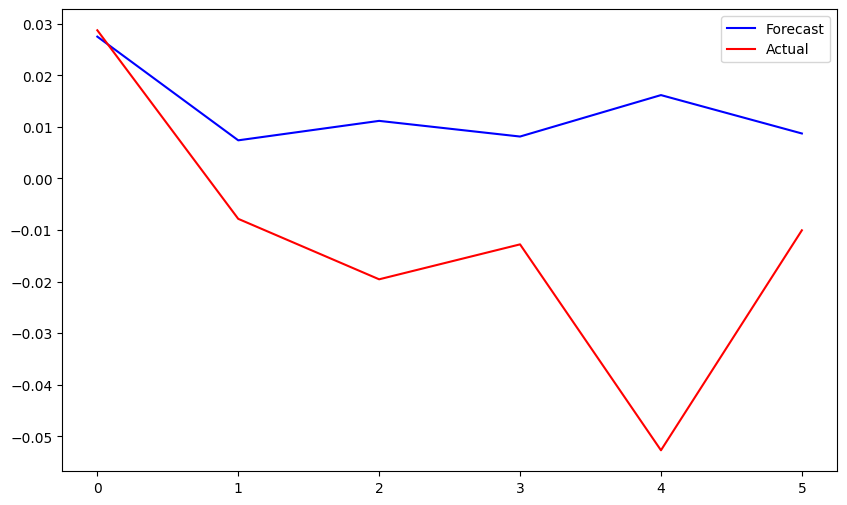

In [356]:
# Trực quan hóa dữ liệu df_tmp1 và df_tmp2
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df_tmp1['Forecast'], label='Forecast', color='blue')
plt.plot(df_tmp2['GARCH_Residuals'], label='Actual', color='red')
plt.legend()
plt.show()


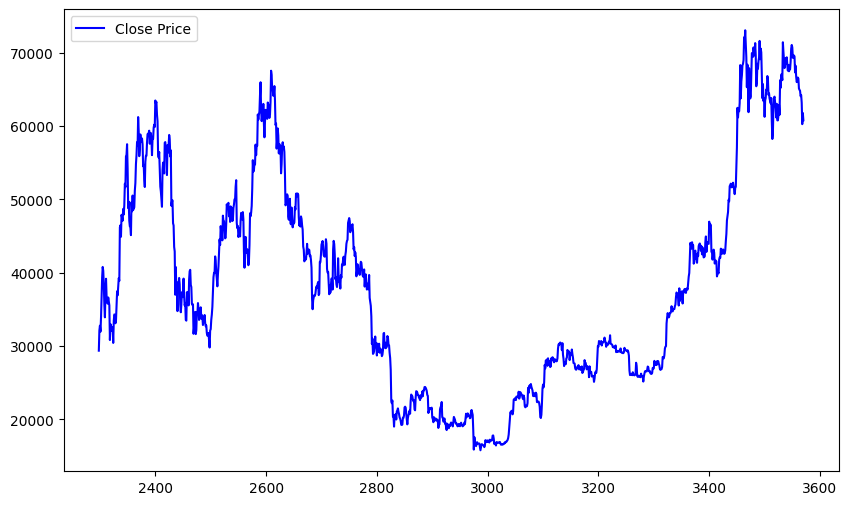

In [352]:
plt.figure(figsize=(10, 6))
plt.plot(df1['Close'], label='Close Price', color='blue')
plt.legend()
plt.show()

In [363]:
# convert Arima_GARCH_Residuals to Forecast_Price which know df1['log_return'] = np.log(df1['Close'] / df1['Close'].shift(1))
df1['Forecast_Price'] = df1['Close']*(1+df1['Arima_GARCH_Residuals'].shift(1))
df1

,Date,Close,log_return,Arma_resid,GARCH_Residuals,Arima_GARCH_Residuals,Forecast_Price
2298,2021-01-01,29374.152344,0.000000,0.000000,-0.000642,-0.000139,NaN
2299,2021-01-02,32127.267578,0.089590,0.089590,0.088948,0.089451,32122.809113
2300,2021-01-03,32782.023438,0.020175,-0.022874,0.019533,-0.023013,35714.415954
2301,2021-01-04,31971.914062,-0.025022,-0.062957,-0.025665,-0.063095,31236.139322
2302,2021-01-05,33992.429688,0.061280,0.037625,0.060638,0.037486,31847.663836
...,...,...,...,...,...,...,...
3566,2024-06-22,64252.578125,0.002437,0.000433,0.001794,0.000294,63405.653980
3567,2024-06-23,63180.796875,-0.016821,-0.018289,-0.017464,-0.018428,63199.356311
3568,2024-06-24,60277.414062,-0.047043,-0.049206,-0.047685,-0.049345,59166.620811
3569,2024-06-25,61804.640625,0.025021,0.021828,0.024379,0.021689,58754.891100


In [358]:
df1

,Date,Close,log_return,Arma_resid,GARCH_Residuals,Arima_GARCH_Residuals,Forecast_Price
2298,2021-01-01,29374.152344,0.000000,0.000000,-0.000642,-0.000139,0.000000
2299,2021-01-02,32127.267578,0.089590,0.089590,0.088948,0.089451,0.089590
2300,2021-01-03,32782.023438,0.020175,-0.022874,0.019533,-0.023013,0.109765
2301,2021-01-04,31971.914062,-0.025022,-0.062957,-0.025665,-0.063095,0.084743
2302,2021-01-05,33992.429688,0.061280,0.037625,0.060638,0.037486,0.146023
...,...,...,...,...,...,...,...
3566,2024-06-22,64252.578125,0.002437,0.000433,0.001794,0.000294,0.782707
3567,2024-06-23,63180.796875,-0.016821,-0.018289,-0.017464,-0.018428,0.765885
3568,2024-06-24,60277.414062,-0.047043,-0.049206,-0.047685,-0.049345,0.718842
3569,2024-06-25,61804.640625,0.025021,0.021828,0.024379,0.021689,0.743863
